#Initializing Spark

In [ ]:
!pip3 -q install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Spark_Pipeline').master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Spark_Pipeline>

##Libraries

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pyspark.sql.functions import mean
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,DecisionTreeClassifier,LinearSVC,NaiveBayes

#DATA

##Load Data

In [ ]:
!wget -O wine.csv -q https://raw.githubusercontent.com/NaVaNKuMaR/winedata/main/wine.csv

In [ ]:
#loading dataset into spark dataframe
df = spark.read.csv('wine.csv', inferSchema=True,header=True)
df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

##Basic EDA

In [ ]:
df.count()

1599

In [ ]:
df.printSchema()

root
 |-- fixed_acidity: double (nullable = true)
 |-- volatile_acidity: double (nullable = true)
 |-- citric_acid: double (nullable = true)
 |-- residual_sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free_sulfur_dioxide: double (nullable = true)
 |-- total-sulfur_dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)
 |-- quality_index: integer (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+-------+-------------------+
|summary|     fixed_acidity|   volatile_acidity|        citric_acid|    residual_sugar|           chlorides|free_sulfur_dioxide|total-sulfur_dioxide|             density|                 pH|         sulphates|           alcohol|quality|      quality_index|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+-------+-------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599| 

AttributeError: ignored

In [ ]:
df.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|    bad|  744|
|   good|  855|
+-------+-----+



In [ ]:
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

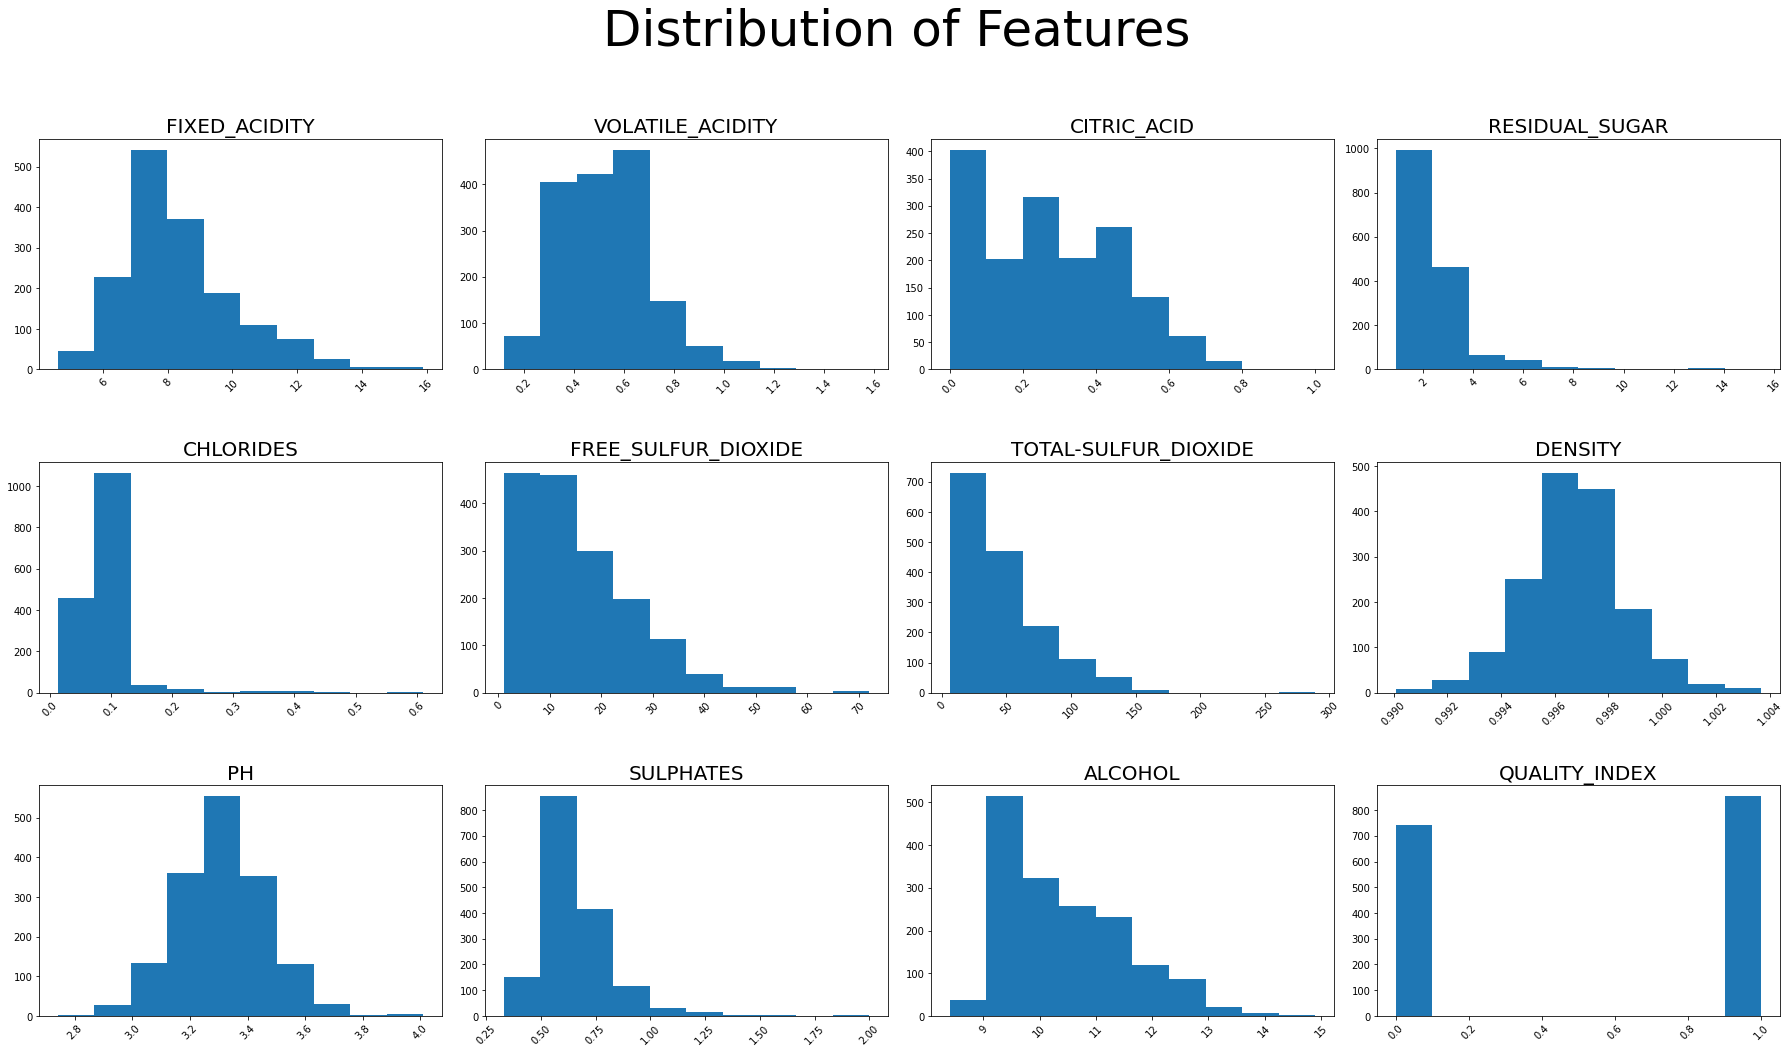

In [ ]:
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().describe().columns, range(1,13)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
     
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total-sulfur_dioxide,density,pH,sulphates,alcohol,quality_index
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


## Using Spark SQL

In [ ]:
df.columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total-sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'quality_index']

In [ ]:
# create DataFrame as a temporary view
df.createOrReplaceTempView('wine_quality_T')

## Data Preprocessing

In [ ]:
#checking null values
df.toPandas().isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total-sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_index           0
dtype: int64

In [ ]:
df.dtypes

[('fixed_acidity', 'double'),
 ('volatile_acidity', 'double'),
 ('citric_acid', 'double'),
 ('residual_sugar', 'double'),
 ('chlorides', 'double'),
 ('free_sulfur_dioxide', 'double'),
 ('total-sulfur_dioxide', 'double'),
 ('density', 'double'),
 ('pH', 'double'),
 ('sulphates', 'double'),
 ('alcohol', 'double'),
 ('quality', 'string'),
 ('quality_index', 'int')]

In [ ]:
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

# Serial Data Conversions

## String Indexer

In [ ]:
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

##One Hot Encoder

In [ ]:
OHE_quality = OneHotEncoder(inputCols=["qualityIndex"], outputCols=["qualityVec"])


In [ ]:
OHE_quality.fit(qualityIndexer.fit(df).transform(df)).transform(qualityIndexer.fit(df).transform(df))
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

##Assembler

In [ ]:
df.columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total-sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'quality_index']

In [ ]:
df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    bad|            0|
|         11.2| 

In [ ]:
df.columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total-sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality',
 'quality_index']

In [ ]:
F_assembler = VectorAssembler(inputCols=['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                                         'total-sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'],outputCol='X')

#Train - Test Split

In [ ]:
train_df,test_df = df.randomSplit([0.7,0.3])
print(train_df.count())
print(test_df.count())

1132
467


In [ ]:
train_df.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+
|          4.7|             0.6|       0.17|           2.3|    0.058|               17.0|               106.0| 0.9932|3.85|      0.6|   12.9|   good|            1|
|          4.9|            0.42|        0.0|           2.1|    0.048|               16.0|                42.0|0.99154|3.71|     0.74|   14.0|   good|            1|
|          5.0|             0.4|        0.5|           4.3|    0.046|               29.0|                80.0| 0.9902|3.49|     0.66|   13.6|   good|            1|
|          5.0| 

In [ ]:
basePipe = Pipeline(stages=[F_assembler])
basePipe.fit(df).transform(df).show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    bad|            0|[7.4,0.7,0.0,1.9,...|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    bad|            0|[7.8,0.88,0.0,2.6...|
|          7.8|            0.76|       0.04|           2.3|    0.092|      

In [ ]:
def model(model):
  model_pipeline = Pipeline(stages=[basePipe,model])                   
  model = model_pipeline.fit(train_df)
  model_predictions=model.transform(test_df)
  model_predictions.show(5)
  acc_evaluator = MulticlassClassificationEvaluator(labelCol="quality_index", predictionCol="prediction", metricName="accuracy")
  evaluator = BinaryClassificationEvaluator(labelCol='quality_index')
  model_acc=acc_evaluator.evaluate(model_predictions)
  print(round(model_acc,3), 'is the accuray of the model pipeline')
  model_auroc = evaluator.evaluate(model_predictions, {evaluator.metricName: "areaUnderROC"})
  print("Area under ROC Curve: {:.4f}".format(model_auroc))

#Logistic Regression

In [ ]:
lr = LogisticRegression(labelCol='quality_index',featuresCol='X',maxIter=5)
model(lr)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|       rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|[-1.8671061204267...|[0.13387692375070...|       1.0|
|          5.0|            0.38|       0.01|    

#Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(labelCol='quality_index',featuresCol='X')
model(dt)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+-------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+-------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|  [1.0,117.0]|[0.00847457627118...|       1.0|
|          5.0|            0.38|       0.01|           1.6|    0.048|       

#Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol = 'quality_index',featuresCol = 'X')
model(rf)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|       rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|[3.66317420896938...|[0.18315871044846...|       1.0|
|          5.0|            0.38|       0.01|    

#Gradient Boost

In [ ]:
gbt = GBTClassifier(labelCol='quality_index',featuresCol='X')
model(gbt)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|       rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|[-1.1742196059289...|[0.08718991217420...|       1.0|
|          5.0|            0.38|       0.01|    

#Linear SVM

In [ ]:
svm=LinearSVC(labelCol='quality_index',featuresCol='X')
model(svm)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|       rawPrediction|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|[-1.5189613033338...|       1.0|
|          5.0|            0.38|       0.01|           1.6|    0.048|               26.0|                60.0|0.99084| 3.7|     0.75

#Naive Bayes

In [ ]:
nb=NaiveBayes(labelCol='quality_index',featuresCol='X')
model(nb)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total-sulfur_dioxide|density|  pH|sulphates|alcohol|quality|quality_index|                   X|       rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-------------+--------------------+--------------------+--------------------+----------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|    bad|            0|[4.6,0.52,0.15,2....|[-126.23050004876...|[0.97453552299799...|       0.0|
|          5.0|            0.38|       0.01|    

### CONCLUSION: The best fit model is Gradient Boost with an accuracy of the pipeline 77.1% and Area under the curve is around 84.23%